# Conexión MySQL y Python para obtener la información
Realitza la connexió en Python amb el MySQL Workbench per a carregar tota la informació que tens en les taules.

### Importar librerias

Para conectar la base de datos, necesitarè instalar el conector de mysql en python. Esto lo hago mediante el comando 'pip install mysql.connector' desde la consola de powershell.
Asi mis mismo iré instalando las librerias para visualización a lo largo del sprint.

In [11]:
# IMPORTAR LAS LIBRERIAS NECESARIAS
import mysql.connector
import pandas as pd
from datetime import datetime
from tabulate import tabulate
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr # lo utilizaré para establecer si existe relacion en alguna variable

## Crear conexión y obtener las tablas

- Para conectar python con MySQL debo establercer la conexión a partir del conector instalado y entregando las credeciales de acceso a la base de datos.
- La base de datos que utilizaré se llama 'trades4' y eso me dará acceso a cada una de las dataframes.
- El siguiente paso es obtener las tablas para obtener los dataframes. 
- a cada tabla la llamaré 'df_{Nombre_de_tabla}

In [12]:
# CREO UNA CONEXIÓN PARA LA BASE DE DATOS 'TRADES4'
cnx = mysql.connector.connect(
    user='root',
    password='250301',
    host='localhost',
    database='trades4')
cursor = cnx.cursor()

# Obtener nombres de las tablas y las almaceno en una lista
cursor.execute("SHOW TABLES")
table_names = [table_name for (table_name,) in cursor.fetchall()] # display(table_names)
print(table_names)
# Obtener DataFrames de las tablas
dfs = {}
for table_name in table_names:
    cursor.execute(f"SELECT * FROM {table_name}")
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    dfs[table_name] = df

# Crear variables globales para cada DataFrame
for table_name, df in dfs.items():
    globals()[f"df_{table_name}"] = df

# Cerrar cursor y conexión
cursor.close()
cnx.close()


['card_status', 'companies', 'credit_cards', 'product_tx', 'products', 'transactions', 'users']


# Exercici 1: Mostrar una variable numérica

#### **Situación de trabajo** 
La empresa desea verificar y describir las edades de los usuarios, estableciendo variables numéricas para analizarlas al máximo. Esto es necesario para desarrollar una estrategia que permita mejorar los productos y plataformas dirigidos a esta demografía.

#### **Desarrollo:** 
1. Primer paso:
   - De la tabla `df_users` obtendré la información de la fecha de nacimiento y con ello calcularé la edad de cada usuario.
2. Segundo paso:
   - A partir de la edad realizaré un boxplot graficando la mediana, percentil 25 y 75
   - Tambien agregaré en el grafico el promedio, edad mínima y máxima. 

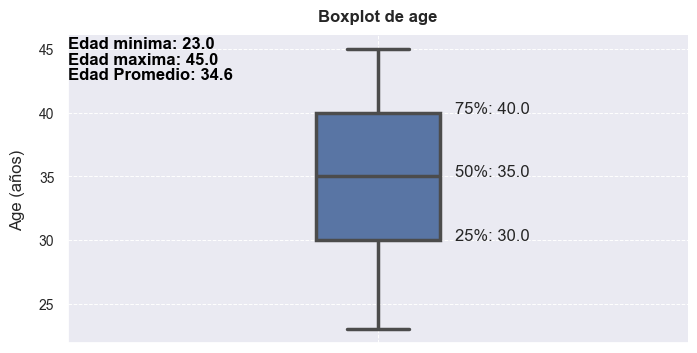

In [13]:
# FUNCIÓN PARA CONVERTIR 'BIRTH_DATE' A FORMATO DE FECHA Y CALCULAR LA EDAD EN AÑOS
df['birth_date'] = pd.to_datetime(df['birth_date'], format='%b %d, %Y')
df['age'] = datetime.now().year - df['birth_date'].dt.year

# FUNCIÓN PARA CREAR UN BOXPLOT
def age_boxplot(df, column):
    sns.set()
    plt.figure(figsize=(8, 4))
    
    # Crear el boxplot
    ax = sns.boxplot(y=df[column], width=0.2, fliersize=5, linewidth=2.5)
    ax.set_title(f'Boxplot de {column}', fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel(f'{column.capitalize()} (años)', fontsize=12, labelpad=10)
    ax.grid(True, linestyle='--', linewidth=0.7)
    ax.yaxis.set_tick_params(labelsize=10)
    sns.despine(top=True, right=True)
    
    # Anotar cuartiles a la derecha
    quartiles = df[column].quantile([0.25, 0.5, 0.75])
    for q, value in quartiles.items():
        label = f'{int(q * 100)}%: {value:.1f}'
        ax.text(0.125, value, label)
    
    # Anotar mínimo, máximo y promedio a la izquierda
    stats = {
        'Edad minima': df[column].min(),
        'Edad maxima': df[column].max(),
        'Edad Promedio': df[column].mean()
    }
    
    # Calcular posición vertical para los textos
    max_value = max(df[column].max(), max(quartiles))
    min_value = min(df[column].min(), min(quartiles))
    vertical_position = max_value + 0.1 * (max_value - min_value)
    
    for i, (stat, value) in enumerate(stats.items(), start=1):
        ax.text(-0.5, vertical_position - i * 1.2, f'{stat}: {value:.1f}', verticalalignment='top', size='medium', color='black', weight='semibold')
    
    plt.show()
age_boxplot(df_users, 'age')



### **Análisis:**
La distribución de las edades de los usuarios revela una edad media de 34 años, con un rango que va desde los 23 hasta los 45 años. Los percentiles 25 y 75 se sitúan en 30 y 40 años, respectivamente, mientras que la mediana es de 35 años. No se observan outliers significativos en la distribución de las edades.

### **Recomendaciones:**

- **Segmentación de Productos:**
  Dado que la mayoría de los usuarios se encuentran entre los 30 y 40 años, es aconsejable desarrollar productos y servicios específicamente adaptados a las necesidades y preferencias de este grupo etario.

- **Estrategia de Marketing:**
  Implementar campañas de marketing que destaquen las características y beneficios más relevantes para los usuarios de entre 23 y 45 años, utilizando canales y mensajes que resuenen con este grupo demográfico amplio y diverso.

- **Plataformas y Experiencia del Usuario:**
  Mejorar las plataformas digitales para hacerlas más intuitivas y funcionales para usuarios de 30 a 40 años. Esto garantizará una experiencia de usuario óptima y adaptada a sus habilidades y expectativas tecnológicas.

- **Monitoreo Continuo:**
  Continuar monitoreando la distribución de edades para identificar cambios demográficos significativos que puedan requerir ajustes estratégicos.




# Exercici 2: Dues variables numèriques.

#### **Situación:**

La empresa ha pedido complementar la informacion anterior solicitado un análisis para determinar la relación entre la edad de los usuarios y su capacidad de compra, representada por la cantidad de dinero que gastan. 

Para llevar a cabo este análisis, es necesario seleccionar dos variables numéricas: la edad de los usuarios y el monto de las compras, que se extraerá de la tabla transactions. El objetivo es identificar patrones y tendencias que puedan informar futuras estrategias de marketing y ventas.

#### **Desarrollo**
Para analizar esta relación, se deben realizar los siguientes pasos:

1. Para esta información, ademas de la tabla de df_users, utilizaré la tabla df_transactions.
2. Realizaré el mismo calculo de la edad de los usuarios a partir de sus fechas de nacimiento.
3. Uniré las tablas df_users y df_transactions en función de los identificadores de usuario (user_id).
4. Obtener un resumen estadístico de las variables seleccionadas.
5. Visualizar la relación entre la edad y la capacidad de compra mediante un scatter plot (diagrama de dispersión).

   
Este análisis permitirá a la empresa comprender mejor el comportamiento de compra de sus usuarios en función de su edad y ajustar sus estrategias de manera más efectiva.

In [14]:
# CONVERTIR 'BIRTH_DATE' A FORMATO DE FECHA Y CALCULAR LA EDAD EN AÑOS
df['birth_date'] = pd.to_datetime(df['birth_date'], format='%b %d, %Y')
df['age'] = datetime.now().year - df['birth_date'].dt.year

# COMO ES UN 'OBJECT' HAGO LA CONVERSIÓN A 'FLOAT' PARA OBTENER LAS METRICAS:
df_transactions['amount'] = df_transactions['amount'].astype(float)

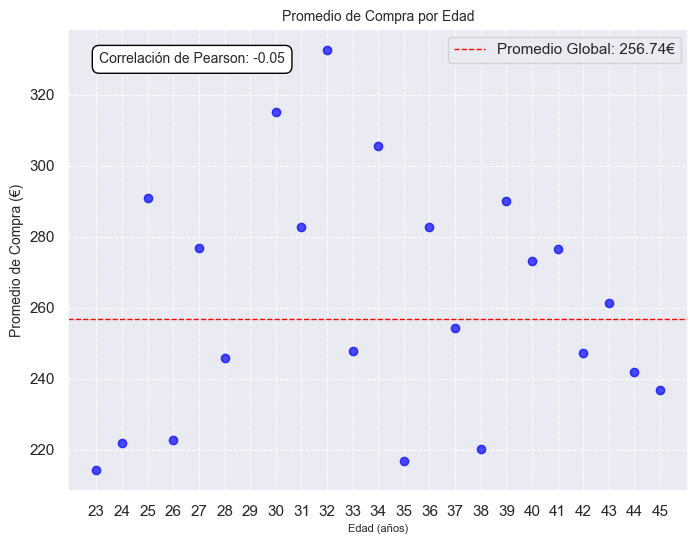

In [15]:
# Fusionar los DataFrames df_transactions y df_users en df_trans_users
df_trans_users = df_transactions.merge(df_users, left_on='user_id', right_on='id')

# Agrupar por edad y calcular el promedio de la cantidad
grouped_by_age = df_trans_users.groupby('age')['amount'].mean().reset_index()

# Calcular el promedio global de amount
global_average = df_trans_users['amount'].mean()

# Calcular correlación de Pearson entre edad y promedio de compra
correlation = grouped_by_age['age'].corr(grouped_by_age['amount'])

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(grouped_by_age['age'], grouped_by_age['amount'], marker='o', color='blue', alpha=0.7)

# Añadir la línea del promedio global
plt.axhline(y=global_average, color='red', linestyle='--', linewidth=1, label=f'Promedio Global: {global_average:.2f}€')

# Configurar título y etiquetas de ejes
plt.title('Promedio de Compra por Edad', fontsize=10)
plt.xlabel('Edad (años)', fontsize=8)
plt.ylabel('Promedio de Compra (€)', fontsize=10)

# Ajustar los ticks del eje X para incluir todas las edades
plt.xticks(grouped_by_age['age'])

# Agregar la correlación de Pearson dentro del gráfico
plt.text(0.05, 0.95, f'Correlación de Pearson: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True, linestyle='--', linewidth=0.7)
plt.show()



#### **Descripción y Análisis**

- Este grafico nos muestra la distribución del promedio de compra segun la edad. Es decir, cada punto representa el potencial de compra de cada edad de los usuario que han hecho transacciones.
- Es posible observar hay una distribuciñon que es uniforme del promedio de compra con respecto a los puntos hacia arriba y hacia abajo. 
- La Correlación de Pearson (-0.05) sugiere una correlación negativa muy débil entre la edad de los usuarios y el promedio de compra que realizan. Esta correlación cercana a cero indica que no hay una relación lineal significativa entre la edad y el promedio de compra. Aunque la correlación es débil, el gráfico de dispersión generado previamente permite visualizar cómo se distribuyen los promedios de compra en diferentes grupos de edad.



#### **Recomendaciones**

- No se puede establecer una tendencia clara de que, a medida que la edad aumenta, el promedio de compra disminuya o viceversa. La edad de los usuarios no parece ser un predictor fuerte del promedio de compra en tu conjunto de datos. Por lo tanto, como consecuencia de este análisis, se puede indicar que la relación entre edad y cantidad de compra no será un factor determinante en el comportamiento de compra. Es necesario explorar otras variables que podrían tener una influencia más fuerte en el promedio de compra, como el nivel de ingresos, el tipo de productos comprados o el canal de compra utilizado.

.... se podria analizar el tipo de producto que se venden, no hay unn target especifico que gaste mucho mas..

# Exercici 3 Una variable categòrica.

#### **Situación:**

- Con el objetivo de investigar las compras perdidas y determinar la necesidad de desarrollar nuevas estrategias, se solicita una variable categórica que permita identificar estos casos. He seleccionado la variable "declined" ya que indica si las transacciones han sido rechazadas, lo cual permite evaluar si es necesario profundizar en este aspecto.

#### **Desarrollo:**

- Una opción habitual consiste en transformar la columna "declined", la cual indica si una transacción fue rechazada o no, en una variable categórica. Esta columna contiene valores binarios, como 0 y 1, lo cual la hace adecuada para esta transformación.

   Los pasos a seguir son los siguientes:

  1. **Convertir la columna declined en una variable categórica:**
      - Vamos a asignar etiquetas categóricas a los valores de la columna declined:       
        - 0 como "No rechazada"
        - 1 como "Rechazada"

  2. **Descripción de esta variable categórica:**
      - Esta variable categórica nos proporcionará información crucial sobre el estado de las transacciones.
      - La categorización nos permitirá entender la frecuencia y la proporción de transacciones rechazadas frente a las aceptadas.
      - Podremos analizar la distribución de las transacciones rechazadas en relación con otras variables, como el tipo de transacción, la cantidad de la compra, o el momento del rechazo (si está disponible).
      - Ayudará a identificar patrones y tendencias que podrían sugerir la necesidad de ajustar políticas de aceptación de transacciones o de mejorar la seguridad para reducir los rechazos.

  Al transformar y describir esta variable categórica, estaremos mejor equipados para tomar decisiones informadas y diseñar estrategias efectivas para optimizar el proceso de transacciones.


declined
0    500
1     87
Name: count, dtype: int64
count     587
unique      2
top         0
freq      500
Name: declined, dtype: object


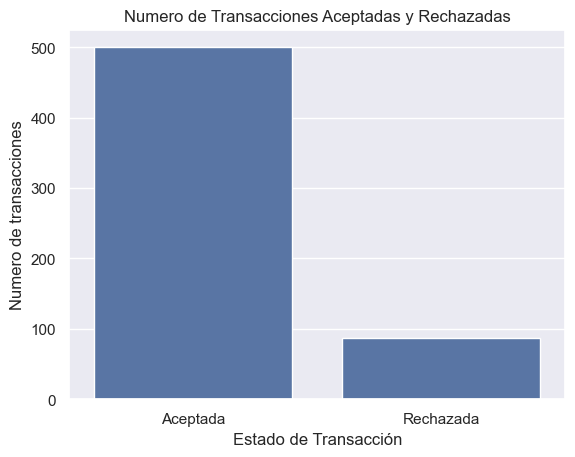

In [16]:
# Convertir la columna 'declined' a una variable categórica
df_transactions['declined'] = df_transactions['declined'].astype('category')

# Calcula la frecuencia de valores y  Muestra la tabla de frecuencias. Esto sera utilizado para saber los valores asocidados al gráfico.
freq_table = df_transactions['declined'].value_counts()
print(freq_table)

# Describir la variable categórica
description = df_transactions['declined'].describe()
print(description)

# Crear el gráfico de barras
sns.countplot(x='declined', data=df_transactions)
plt.title('Numero de Transacciones Aceptadas y Rechazadas')
plt.xlabel('Estado de Transacción')
plt.ylabel('Numero de transacciones')
plt.xticks(ticks=[0, 1], labels=['Aceptada', 'Rechazada'])
plt.show()

#### **Analisis:**


- **Valores y frecuencia:**
  - Hay un total de 587 registros en la columna "declined".
  - Se observan dos valores únicos: 0 y 1.
  - El valor más frecuente es 0, con una frecuencia de 500 veces.

Esta variable categórica indica si las transacciones fueron rechazadas (1) o no (0). Según los datos proporcionados, la mayoría de las transacciones (500 de 587) fueron aceptadas, mientras que 87 transacciones sí fueron rechazadas. Este análisis inicial nos permite entender la distribución y la proporción de transacciones rechazadas en relación con las aceptadas, lo cual es crucial para evaluar la efectividad y la seguridad del proceso de transacciones.


#### **Recomendaciones:**

1. **Análisis de Causas de Rechazo:**
   - Esto puede incluir problemas de validación de tarjetas, límites de crédito insuficientes, o medidas de seguridad activadas.
   - Implementar sistemas de registro detallado de los motivos de rechazo para identificar patrones recurrentes.

2. **Optimización de Políticas de Aprobación:**
   - Revisar y ajustar las políticas de aprobación de transacciones para minimizar los rechazos injustificados sin comprometer la seguridad. Se podrían considerar la actualización de los límites de crédito o la implementación de criterios más flexibles basados en comportamientos históricos de los usuarios.

3. **Mejora en la Experiencia del Usuario:**
   - Ofrecer retroalimentación clara y rápida a los usuarios cuando una transacción sea rechazada, indicando los pasos necesarios para resolver el problema.

4. **Monitoreo Continuo y Evaluación de Resultados:**
   - Establecer métricas clave para monitorear la tasa de rechazo de transacciones y su impacto en las ventas y la satisfacción del cliente.
   - Realizar revisiones periódicas de los datos para evaluar la efectividad de las estrategias implementadas y realizar ajustes según sea necesario.

5. **Capacitación y Actualización del Personal:**
   - Capacitar al personal involucrado en el procesamiento de transacciones para manejar eficazmente situaciones de rechazo y ofrecer soporte adecuado a los clientes afectados.

Implementar estas recomendaciones ayudará a mitigar las compras perdidas debido a rechazos de transacciones, mejorando así la eficiencia operativa  y la satisfacción del cliente en el proceso de compra.


# Ejercicio 4: Una variable categórica y una numérica.

####  **Situación:**

La empresa ha solicitado realizar un análisis detallado de los montos asociados a transacciones declinadas y no declinadas. El objetivo es identificar patrones y diferencias significativas entre estos dos grupos, lo cual será fundamental para optimizar estrategias empresariales relacionadas con la gestión de transacciones y la mejora de la experiencia del cliente.

#### **Desarrollo:**

Para obtener la visualización sigo los siguientes pasos: 
1. Tomo las variables de 'declined' como categorica y 'amount' como continua. 
2. Gráfico de barras: Muestra la frecuencia de transacciones aceptadas y rechazadas.
3. Boxplot para mostrar la distribución de los montos (amount) para transacciones aceptadas y rechazadas.

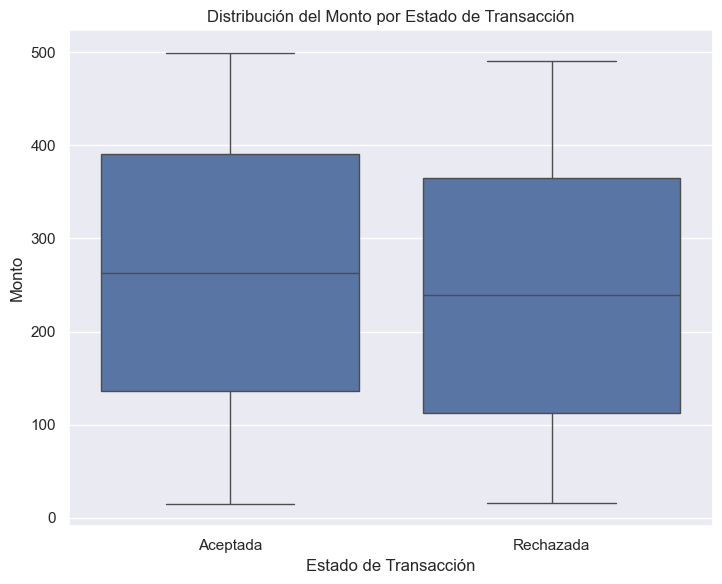

In [17]:
plt.figure(figsize=(14, 6))

# Gráfico de caja de la variable numérica 'amount' por la categórica 'declined'
plt.subplot(1, 2, 2)
sns.boxplot(x='declined', y='amount', data=df_transactions)
plt.title('Distribución del Monto por Estado de Transacción')
plt.xlabel('Estado de Transacción')
plt.ylabel('Monto')
plt.xticks(ticks=[0, 1], labels=['Aceptada', 'Rechazada'])

plt.tight_layout()
plt.show()


#### Análisis
Se observa que la media de los montos en ambos grupos (Aceptada y Rechazada) es muy similar. Tanto los rangos intercuartílicos como la mediana también muestran similitudes. Es importante destacar que el número de transacciones aceptadas es significativamente mayor que el de las rechazadas. El gráfico no refleja esta disparidad, por lo que, si no se tiene en cuenta, podría llevar a interpretaciones incorrectas.

#### Recomendaciones

No es posible establecer recomendaciones basadas únicamente en estos datos. Es necesario considerar otras variables para un análisis más completo, como el tipo de transacción, el país de origen o el producto. Para una correcta interpretación y la toma de decisiones adecuadas, es esencial complementar esta información con otras variables.

# Exercici 5: Dues variables categòriques.

#### **Situación:**

La empresa desea identificar la relación entre el pais de origen del ususario y el estado de las transacciones para optimizar sus esfuerzos y evitar pérdidas financieras.


### **Desarrollo:**

Para abordar esta situación, se llevará a cabo el siguiente análisis:

1. **Unión de Tablas:**
   - Se unirá la tabla `df_transactions` con la tabla `df_users` utilizando la columna `user_id`. Esta unión permitirá enriquecer los datos de transacciones con información adicional de los usuarios, como el país de origen.
2. **Definir las Variables Categóricas:**
   - Me aseguro que se reconocerà como variable categorica. Esto facilitará el análisis y la visualización de los datos. 
3. **Análisis de Relación País - Estado de Transacciones:**
   - Se explorará cómo varía el estado de las transacciones (aceptadas o rechazadas) en diferentes países.
   - Esto permitirá identificar patrones y tendencias que puedan indicar áreas geográficas con mayores incidencias de transacciones rechazadas.

Este enfoque permitirá a la empresa tomar decisiones informadas y estratégicas para optimizar sus operaciones globales y reducir las pérdidas asociadas con transacciones rechazadas.



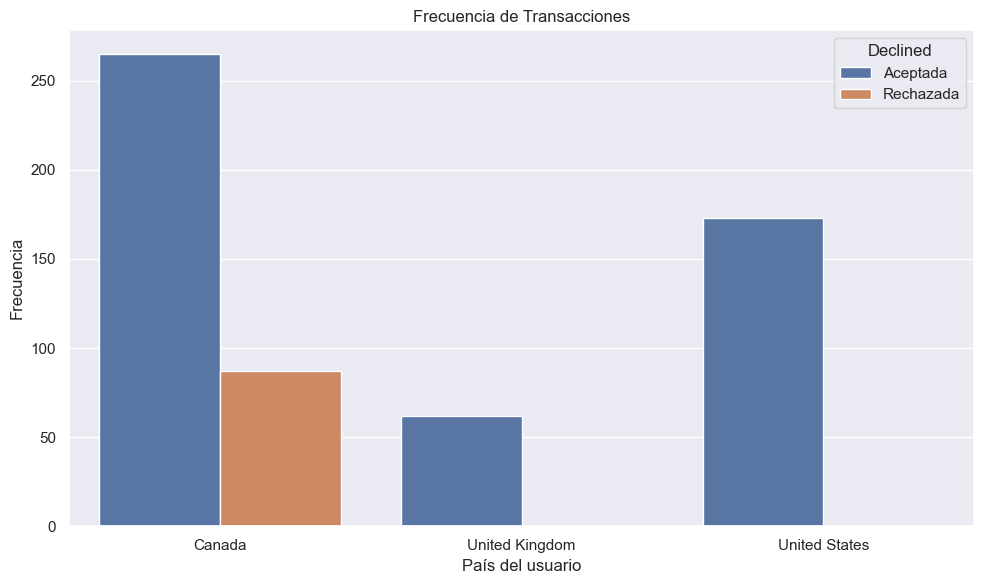

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Unir las tablas df_transactions y df_users usando user_id
merged_df = pd.merge(df_transactions, df_users, left_on='user_id', right_on='id', suffixes=('_transaction', '_user'))

# Convertir 'declined' y 'country' en variables categóricas
merged_df['declined'] = merged_df['declined'].astype('category')
merged_df['country'] = merged_df['country'].astype('category')

# Graficar los datos
plt.figure(figsize=(10, 6))

# Gráfico de conteo para las variables categóricas 'declined' y 'country'
sns.countplot(x='country', hue='declined', data=merged_df)
plt.title('Frecuencia de Transacciones')
plt.xlabel('País del usuario')
plt.ylabel('Frecuencia')
plt.legend(title='Declined', labels=['Aceptada', 'Rechazada'])

plt.tight_layout()
plt.show()

### Analisis

Es evidente que los usuarios de Canadá son los únicos que presentan transacciones rechazadas, a diferencia de los usuarios de Reino Unido y Estados Unidos, quienes no experimentan este problema. Este patrón sugiere que las transacciones rechazadas están vinculadas de manera exclusiva a los usuarios canadienses.

En Canadá, las transacciones aceptadas varían entre 250 y 260, mientras que las rechazadas están aproximadamente entre 80 y 90. En el Reino Unido, las transacciones aceptadas son aproximadamente 50 y no se registran transacciones rechazadas. En Estados Unidos, las transacciones aceptadas son aproximadamente 150, también sin rechazos.

Estos datos indican que, aunque Canadá tiene una alta frecuencia de transacciones aceptadas, también enfrenta un número significativo de rechazos. En comparación, tanto Reino Unido como Estados Unidos tienen menores frecuencias de transacciones aceptadas pero no presentan rechazos. Esto subraya un problema específico en el sistema de transacciones para los usuarios canadienses que debe ser abordado.

### Recomendaciones

Dado que los usuarios con transacciones rechazadas provienen principalmente de Canadá, es fundamental desarrollar un plan de acción específico para abordar esta situación. Desde este punto sería posible recomendar: 

- Establecer alianzas estratégicas con bancos locales en Canadá para mejorar el proceso de aprobación de transacciones. Esto podría implicar la integración de sistemas o la negociación de acuerdos para facilitar las compras internacionales.

- Realizar un estudio exhaustivo para identificar las posibles barreras que enfrentan los usuarios canadienses al realizar compras internacionales. Esto podría abarcar desde restricciones impuestas por los bancos hasta políticas de seguridad más estrictas.

- Potenciar y adaptar el sistema de compras para asegurar que sea compatible y eficiente con las instituciones financieras canadienses. Esto podría incluir la implementación de métodos de pago alternativos que sean más aceptados en Canadá.

Es posible que las dificultades con los bancos canadienses se deban a políticas más restrictivas en comparación con las de Reino Unido o Estados Unidos. Abordar estas diferencias de manera proactiva puede mejorar significativamente la tasa de éxito en las transacciones y fortalecer la confianza de los usuarios canadienses en el sistema de compras.

# Exercici 6: Tres variables.

### Situacion:

Como complemento al ejercicio anterior, la empresa solicita un análisis adicional que ofrezca más detalles sobre las transacciones aceptadas y rechazadas. Para ello, he decidido estudiar tres variables: el estado de las transacciones, el país de las compañias y el monto asociado a cada transacción. Al investigar estas variables, espero identificar patrones que puedan ayudar a mejorar el rendimiento de la empresa y optimizar sus procesos de transacción.


# Desarrollo: cambiar....

En este análisis, hemos trabajado con tres variables clave para entender mejor las transacciones aceptadas y rechazadas. Las variables categóricas seleccionadas (declined y country) nos permiten distinguir el estado de las transacciones y su origen geográfico. La variable numérica (amount) proporciona información sobre el valor de las transacciones.

Primero, unimos la tabla df_transactions con la tabla df_users usando el campo user_id. Luego, unimos este resultado con la tabla df_companies utilizando el campo business_id. Convertimos las columnas declined y country en variables categóricas para facilitar el análisis y la visualización de los datos.

Finalmente, creamos un gráfico de barras que muestra el monto total de las transacciones agrupadas por país y estado de transacción (aceptada o rechazada). Este gráfico nos ayuda a identificar patrones y diferencias en el comportamiento de las transacciones según el país de origen y su estado, proporcionando información valiosa para mejorar las estrategias y operaciones de la empresa.

<Figure size 1200x800 with 0 Axes>

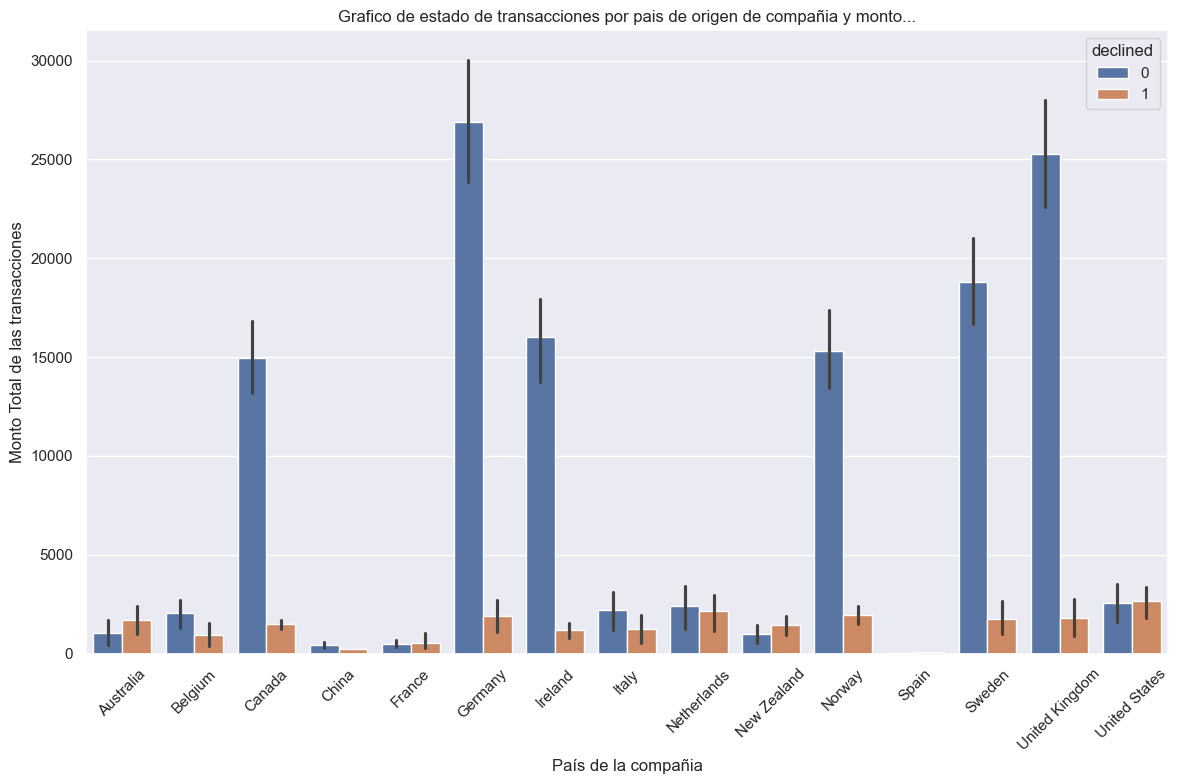

In [19]:
# Suponiendo que 'id' en df_companies corresponde a 'business_id' en df_transactions
merged_df = pd.merge(df_transactions, df_users, left_on='user_id', right_on='id', suffixes=('_transaction', '_user'))
merged_df = pd.merge(merged_df, df_companies, left_on='business_id', right_on='company_id')

# Convertir 'declined' y 'country' en variables categóricas
merged_df['declined'] = merged_df['declined'].astype('category')
merged_df['country_y'] = merged_df['country_y'].astype('category')

# Graficar los datos
plt.figure(figsize=(12, 8))

# Gráfico de barras agrupadas con 'amount' por 'country' y 'declined'
plt.figure(figsize=(12, 8))
sns.barplot(x='country_y', y='amount', hue='declined', data=merged_df, estimator=sum)
plt.title('Grafico de estado de transacciones por pais de origen de compañia y monto...')
plt.xlabel('País de la compañia')
plt.ylabel('Monto Total de las transacciones')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Analisis:**

El gráfico compara las transacciones aceptadas y rechazadas en diferentes países. Las barras que representan las transacciones aceptadas son significativamente más altas que las rechazadas, lo que indica una mayor cantidad de transacciones exitosas. Este tipo de análisis puede ser útil para evaluar tendencias en el procesamiento de transacciones o el rendimiento de sistemas financieros en distintas ubicaciones. En el caso de españa no se ven datos, debido al bajo monto de compra. 

españa llama la anteción que este en blanco por el bajo numero de transacciones y las dos estan aprobadas.

los paises con mas ventas.... ordenn..

llama la antecion que en usa se vende lo mismo que se rechaza... 

### Recomendaciones

canada de 

** aumentar la presencia en españa considerando aumento de venta en general,
,mejorar la comunicacion con China y establecer analisis de mercado para tener productos de interes para estos usuarios/compañis
** ver acciones para mejorar proceso de compra en usa de las empresas....
** Revisar cuales pueden ser los motivos de las compañias para declinar la compra....
** puede haber problemas en los formatos de cada pais que quiza puede ser un motivo por el que la compra no es exitosa.

# Exercici 7: graficas un pairplot

#### Situacion 

El pairplot mostrará todas las relaciones posibles entre las variables numéricas, ayudando a identificar correlaciones y patrones entre las variables transaccionales.



Index(['country_trans', 'country_comp', 'declined', 'amount', 'age',
       'age_group'],
      dtype='object')


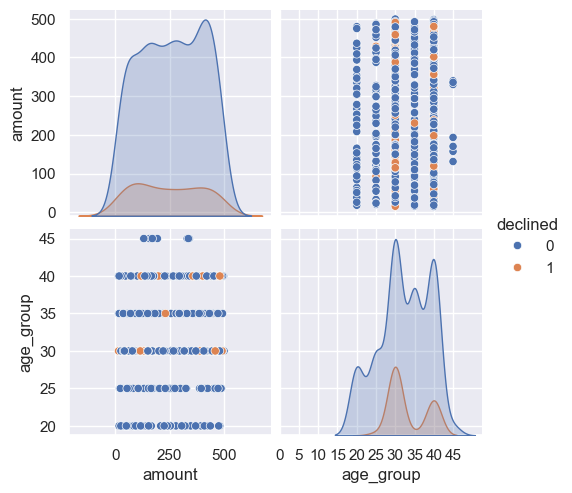

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Supongamos que ya tienes cargados los DataFrames df_companies, df_credit_cards, df_transactions, df_users

# Unir las tablas df_transactions y df_credit_cards
merged_df = pd.merge(df_transactions, df_credit_cards, left_on='card_id', right_on='id', suffixes=('_trans', '_card'))

# Unir df_users al merged_df
merged_df2 = pd.merge(merged_df, df_users, left_on='user_id_trans', right_on='id', suffixes=('_trans', '_user'))

# Si también necesitas incluir df_companies
merged_df3 = pd.merge(merged_df2, df_companies, left_on='business_id', right_on='company_id', how='left', suffixes=('_trans', '_comp'))

# Calcular la edad a partir de la fecha de nacimiento
merged_df3['birth_date'] = pd.to_datetime(merged_df3['birth_date'], format='%b %d, %Y')  # Convertir a tipo datetime si no está ya convertida
merged_df3['age'] = datetime.now().year - merged_df3['birth_date'].dt.year  # Calcular la edad en años

# Crear un grupo de edades cada 5 años
merged_df3['age_group'] = (merged_df3['age'] // 5) * 5

# Definir variables categóricas y numéricas
categorical_columns = ['country_trans', 'country_comp', 'declined']  # Incluir 'declined' como categórica
numeric_columns = ['amount', 'age', 'age_group']  # Incluir la edad y grupo de edad como columnas numéricas

# Filtrar el DataFrame para incluir solo las columnas relevantes y eliminar filas con NaN
plot_data = merged_df3[categorical_columns + numeric_columns].dropna()

# Imprimir las columnas seleccionadas
print(plot_data.columns)

# Crear el pairplot diferenciando por la columna 'declined' y utilizando el grupo de edad
sns.pairplot(plot_data, hue='declined', vars=['amount', 'age_group'])

# Personalizar el gráfico para que muestre la edad cada 5 años en el eje x
plt.xticks(range(0, int(plot_data['age'].max()) + 1, 5))

plt.show()


## Análisis

El análisis del gráfico revela varios insights significativos sobre las transacciones y los usuarios involucrados. En cuanto a la distribución de la cantidad por transacción, se observa que la mayoría de las transacciones tienen un monto cercano a 500, con una mayor densidad en los montos más altos. Por otro lado, las transacciones rechazadas son notablemente menos frecuentes y generalmente implican montos más bajos en comparación con las transacciones aprobadas, que dominan en términos de cantidad y ocurrencia.

En relación con la edad de los usuarios (age_group), se destaca que existe una concentración significativa en los grupos de edad de 25 a 45 años, indicando que este segmento demográfico realiza la mayoría de las transacciones. Aunque no se observa una tendencia clara que vincule directamente el monto de la transacción con el grupo de edad, se percibe una distribución uniforme de transacciones a lo largo de los diferentes grupos de edad, con una ligera concentración entre los 25 y 45 años.

Además, al examinar la relación específica entre el grupo de edad y el monto de la transacción, se confirma la ausencia de una correlación evidente. Las transacciones rechazadas muestran una dispersión mayor a través de diferentes grupos de edad y montos, lo que sugiere una evaluación más diversa por parte de los criterios de riesgo establecidos.

En resumen, el análisis subraya que las transacciones aprobadas tienden a ser de montos más altos, reflejando confianza en el sistema de aprobación para sumas significativas. Asimismo, la concentración de usuarios entre 25 y 45 años destaca como el grupo más activo en términos de uso de tarjetas de crédito, mientras que la relación entre el monto de la transacción y la edad del usuario permanece menos definida, indicando una participación generalizada de todos los grupos de edad en transacciones de diversos montos.

#### Conclusiones

- La mayoría de las transacciones aprobadas son de montos altos, lo cual sugiere una confianza en el sistema de aprobación para montos elevados.
- Las transacciones se concentran en usuarios de entre 25 y 45 años, lo que puede indicar que este es el grupo de edad más activo en términos de uso de tarjetas de crédito. --> Esto es coherente con los resultados de....

- No hay una relación clara entre el monto de la transacción y el grupo de edad del usuario, lo que sugiere que todos los grupos de edad realizan transacciones de diversos montos.
- Las transacciones rechazadas son menos comunes y tienden a tener montos menores, lo que puede estar relacionado con criterios de riesgo establecidos por la entidad financiera.
- rango entre 20, 25 y 45 no tienen rechazo.... 

Este análisis puede ayudar a entender mejor el comportamiento de los usuarios en términos de edad y montos de transacción, y cómo las decisiones de aprobación/rechazo afectan a diferentes segmentos de usuarios.
